# Project: Customer Clusterization

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

# Data Preparation

In [3]:
df_raw = pd.read_csv("data.csv", low_memory=False)

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice       object
CustomerID     float64
Country         object
dtype: object

In [7]:
df1["Country"].value_counts().head()

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64

In [8]:
# Since the UK is by far the most common country, we'll be working only with UK customers for now
df1 = df1.copy()[df1["Country"] == "United Kingdom"]

In [9]:
# Filtering any order without a customer ID
df1 = df1.dropna(axis="index", subset=["CustomerID"])

In [22]:
df1.loc[df1["Quantity"] < 0 , "StockCode"].value_counts()

22423     148
M         134
D          74
22960      69
22720      60
         ... 
21248       1
85049E      1
21206       1
85199L      1
23843       1
Name: StockCode, Length: 1756, dtype: int64

There appear to be three cases where the quantity is negative: The stock code is "D" indicating a discount, "M" possibly indicating a manual change, and a sequence of numbers, representing a returned product or cancelled purchase.

For the purposes of this customer fidelity clusterization project, the former two will be ignored when counting the total number of purchases, while returns will be subtracted. THe monetary value of all transactions will be added, negative or positive.

In [40]:
df1[df1["CustomerID"] == 16042.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3911,C536734,22780,LIGHT GARLAND BUTTERFILES PINK,-4,2010-12-02 12:50:00,4.25,16042.0,United Kingdom
3912,C536734,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2010-12-02 12:50:00,7.95,16042.0,United Kingdom
21697,C538109,22780,LIGHT GARLAND BUTTERFILES PINK,-4,2010-12-09 15:23:00,4.25,16042.0,United Kingdom
21698,C538109,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2010-12-09 15:23:00,7.95,16042.0,United Kingdom
53181,540822,22780,LIGHT GARLAND BUTTERFILES PINK,4,2011-01-11 13:25:00,4.25,16042.0,United Kingdom
...,...,...,...,...,...,...,...,...
478912,577109,23007,SPACEBOY BABY GIFT SET,1,2011-11-17 17:50:00,16.95,16042.0,United Kingdom
478913,577109,23010,CIRCUS PARADE BABY GIFT SET,1,2011-11-17 17:50:00,16.95,16042.0,United Kingdom
478914,577109,23008,DOLLY GIRL BABY GIFT SET,1,2011-11-17 17:50:00,16.95,16042.0,United Kingdom
478915,577109,23367,SET 12 COLOUR PENCILS SPACEBOY,16,2011-11-17 17:50:00,0.65,16042.0,United Kingdom


In [38]:
df1[(df1["CustomerID"] == 13047.0) & (df1["Quantity"] < 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47162,C540391,22274,FELTCRAFT DOLL EMILY,-1,2011-01-06 18:02:00,2.95,13047.0,United Kingdom
140191,C548374,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,-1,2011-03-30 16:36:00,4.25,13047.0,United Kingdom
140192,C548374,21658,GLASS BEURRE DISH,-2,2011-03-30 16:36:00,3.95,13047.0,United Kingdom
140193,C548374,22969,HOMEMADE JAM SCENTED CANDLES,-2,2011-03-30 16:36:00,1.45,13047.0,United Kingdom
228294,C556920,21658,GLASS BEURRE DISH,-1,2011-06-15 13:49:00,3.95,13047.0,United Kingdom
228295,C556920,23126,FELTCRAFT GIRL AMELIE KIT,-2,2011-06-15 13:49:00,4.95,13047.0,United Kingdom
256304,C559486,23245,SET OF 3 REGENCY CAKE TINS,-2,2011-07-08 13:51:00,4.95,13047.0,United Kingdom
256305,C559486,23236,DOILEY STORAGE TIN,-1,2011-07-08 13:51:00,2.89,13047.0,United Kingdom
256306,C559486,23110,PARISIENNE KEY CABINET,-2,2011-07-08 13:51:00,5.75,13047.0,United Kingdom
256307,C559486,23118,PARISIENNE JEWELLERY DRAWER,-1,2011-07-08 13:51:00,7.50,13047.0,United Kingdom


In [68]:
# Drop columns that won't be used in this analysis.
df1 = df1.drop(columns=["Description", "StockCode", "Country"])

In [70]:
df1["InvoiceDate"] = df1["InvoiceDate"].astype("datetime64")
df1["UnitPrice"] = df1["UnitPrice"].str.replace(pat=",", repl="") # Remove the thousands separator
df1["UnitPrice"] = df1["UnitPrice"].astype(float)
df1["CustomerID"] = df1["CustomerID"].astype(int)

In [71]:
df1.dtypes

InvoiceNo              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
dtype: object

# Exploratory Data Analysis

In [72]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


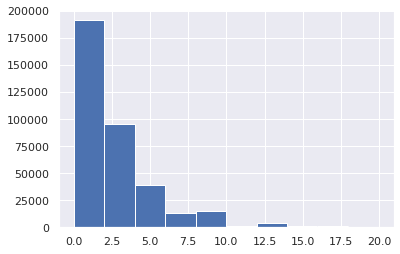

In [73]:
plt.hist(df1["UnitPrice"][ df1["UnitPrice"] < 20 ]);

In [74]:
count1 = df1["InvoiceNo"][df1["UnitPrice"] < 20].count()
count2 = df1["InvoiceNo"].count()
print(f"{count1} out of {count2} purchases were under $20, or {count1/count2:.2%} of the total.")

361028 out of 361878 purchases were under $20, or 99.77% of the total.


The vast majority of the purchases made on this database were of small value, as seen on the histogram.

In [75]:
df1["CustomerID"].value_counts().median()

41.0

In [76]:
count1 = (df1["CustomerID"].value_counts()>50).sum()
count2 = df1["CustomerID"].nunique()
print(f"{count1} out of {count2} customers made more than 50 purchases, or {count1/count2:.2%} of the total.")

1732 out of 3950 customers made more than 50 purchases, or 43.85% of the total.


In contrast, there's a a more even distribution of number of purchases, with many customers having made over 50 purchases in total.

# Feature Engineering

We'll create a new dataframe where each row represents a customer.

In [77]:
df2 = pd.DataFrame(df1["CustomerID"].unique(), columns=["CustomerID"])

The first feature we'll introduce is the *Total Revenue*, the sum of all the purchases the customer made so far. 

In [78]:
# First, we sum the amount of money spent on each purchase
df1["Subtotal"] = df1["Quantity"] * df1["UnitPrice"]
# Then we group the purchases from each customer and add it to the customer dataframe
aux = df1[["CustomerID", "Subtotal"]].groupby("CustomerID").sum().reset_index()
aux.columns=["CustomerID","TotalRevenue"]
if "TotalRevenue" in df2.columns:
    df2 = df2.drop(columns=["TotalRevenue"]) # In case there's already a column with that name, to avoid duplocation
df2 = pd.merge(df2, aux, on="CustomerID", how="left")

Another feature will be *Recency*, that is, the time since the last purchase.

In [79]:
# First, we'll use the last invoice date as the current time
curr_time = df1["InvoiceDate"].max()
df1["Recency"] = (curr_time - df1["InvoiceDate"]).dt.days
# Then the data for each customer is added to the dataframe
aux = df1[["Recency", "CustomerID"]].groupby("CustomerID").min().reset_index()
if "Recency" in df2.columns:
    df2 = df2.drop(columns=["Recency"]) # In case there's already a column with that name, to avoid duplocation
df2 = pd.merge(df2, aux, on="CustomerID", how="left")

Finally, *Frequency* will be the total amount of purchases the customer made during the recorded period.

In [80]:
aux = df1[["CustomerID", "InvoiceNo"]].groupby("CustomerID").nunique().reset_index()
aux.columns = ["CustomerID", "Frequency"]
if "Frequency" in df2.columns:
    df2 = df2.drop(columns=["Frequency"]) # In case there's already a column with that name, to avoid duplocation
df2 = pd.merge(df2, aux, on="CustomerID", how="left")

We will use those features for now. The shape of the data can be visualized, so that we can see if it needs to be scaled or remapped.

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

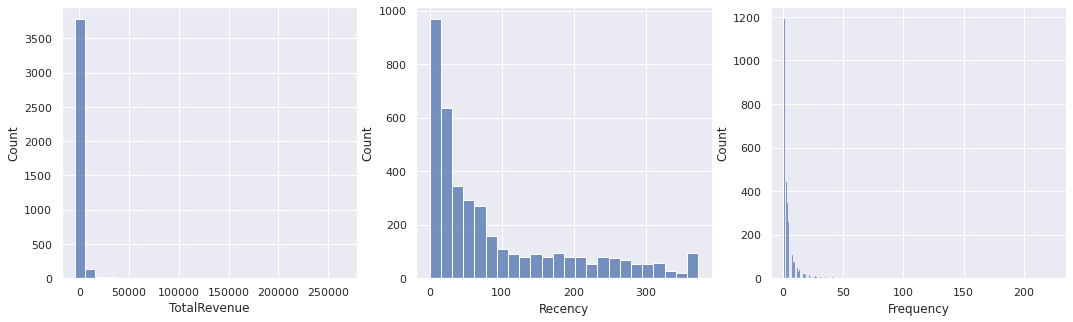

In [81]:
fig, ax = plt.subplots(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
sns.histplot(df2["TotalRevenue"], binwidth=10000, ax=ax1)
ax2 = plt.subplot(1,3,2)
sns.histplot(df2["Recency"], ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.histplot(df2["Frequency"], ax=ax3)

In [82]:
df1[df1["CustomerID"] == 12346]

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Subtotal,Recency
61619,541431,74215,2011-01-18 10:01:00,1.04,12346,77183.6,325
61624,C541433,-74215,2011-01-18 10:17:00,1.04,12346,-77183.6,325


In [88]:
df2[df2["CustomerID"] == 12346]

,CustomerID,TotalRevenue,Recency,Frequency
1059,12346,0.0,325,2


In [83]:
df2["TotalRevenue"].sort_values(ascending=False)

418     256438.49
372     187482.17
14       88125.38
804      65892.08
34       62653.10
          ...    
153       -840.76
1784     -1165.30
198      -1192.20
2805     -1592.49
2803     -4287.63
Name: TotalRevenue, Length: 3950, dtype: float64

In [86]:
df2.iloc[2803]

CustomerID      17448.00
TotalRevenue    -4287.63
Recency           144.00
Frequency           1.00
Name: 2803, dtype: float64

In [84]:
df2.iloc[392]

CustomerID      14673.0
TotalRevenue     1736.4
Recency             2.0
Frequency           5.0
Name: 392, dtype: float64

In [85]:
df1[df1["CustomerID"] == 18102]

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Subtotal,Recency
16425,537657,408,2010-12-07 16:42:00,4.78,18102,1950.24,366
16426,537657,30,2010-12-07 16:42:00,19.84,18102,595.20,366
16427,537657,972,2010-12-07 16:42:00,2.31,18102,2245.32,366
16428,537657,972,2010-12-07 16:42:00,2.31,18102,2245.32,366
16429,537657,408,2010-12-07 16:42:00,6.38,18102,2603.04,366
...,...,...,...,...,...,...,...
540066,581457,126,2011-12-08 18:43:00,3.90,18102,491.40,0
540067,581457,126,2011-12-08 18:43:00,3.57,18102,449.82,0
540068,581457,126,2011-12-08 18:43:00,3.90,18102,491.40,0
540069,581457,126,2011-12-08 18:43:00,4.15,18102,522.90,0


In [87]:
df_raw[df_raw["CustomerID"] == 18102]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
16425,537657,82484,WOOD BLACK BOARD ANT WHITE FINISH,408,2010-12-07 16:42:00,4.78,18102.0,United Kingdom
16426,537657,22830,UTILTY CABINET WITH HOOKS,30,2010-12-07 16:42:00,19.84,18102.0,United Kingdom
16427,537657,22189,CREAM HEART CARD HOLDER,972,2010-12-07 16:42:00,2.31,18102.0,United Kingdom
16428,537657,22188,BLACK HEART CARD HOLDER,972,2010-12-07 16:42:00,2.31,18102.0,United Kingdom
16429,537657,21623,VINTAGE UNION JACK MEMOBOARD,408,2010-12-07 16:42:00,6.38,18102.0,United Kingdom
...,...,...,...,...,...,...,...,...
540066,581457,23535,WALL ART BICYCLE SAFETY,126,2011-12-08 18:43:00,3.90,18102.0,United Kingdom
540067,581457,23530,WALL ART ONLY ONE PERSON,126,2011-12-08 18:43:00,3.57,18102.0,United Kingdom
540068,581457,23526,WALL ART DOG LICENCE,126,2011-12-08 18:43:00,3.90,18102.0,United Kingdom
540069,581457,23401,RUSTIC MIRROR WITH LACE HEART,126,2011-12-08 18:43:00,4.15,18102.0,United Kingdom


In [ ]:
d